미션!

- scale 불량현상의 원인을 찾고, 개선을 위한 최적의 조건을 도출하자

발생원인 : 압입흠, 스크레치, 두께부족, scale
    
잠재 인자 선정 및 방향성 확인
도출된 잠재 인자와 분석 결과 비교예정

범주형 변수의 경우 더미함수를 사용해서 숫자형 데이터로 만들자
- 단, FUR_NO : 가열로 호기의 경우 선형관계가 아니므로 더미를 하면안된다.

분석방향)
- 목표변수가 불량 발생 여부를 구분하는 이산형으로 분류모델을 이용하여 핵심인자를 추출하자
- 도출된 핵심인자와 사전에 검토한 잠재 인자와의 일치 여부 및 방향성 확인
- 불량 개선을 위한 최적 조건 탐색 및 (기술적)검토
- 

In [36]:
# 필요한 라이브러리 import
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib
import seaborn as sns
import time
for f in fm.fontManager.ttflist:
    if 'NanumBarunGothic' in f.fname:
        plt.rcParams['font.family'] = 'NanumBarunGothic' # 폰트를 나눔고딕으로
print(plt.rcParams['font.family'])
matplotlib.rcParams['axes.unicode_minus'] = False #'-'기호 제대로 나오게함

['NanumBarunGothic']


<h3> 데이터 불러오기 <h3>

In [37]:
df_scale = pd.read_csv("./data/SCALE불량.csv",encoding = 'euc-kr')
df_scale.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


<h4> 데이터 내부 결측치 개수 확인 <h4>

In [38]:
# 확인결과 결측치는 없다.
df_scale.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

In [39]:
df_scale.columns

Index(['PLATE_NO', 'ROLLING_DATE', 'SCALE', 'SPEC', 'STEEL_KIND', 'PT_THK',
       'PT_WDTH', 'PT_LTH', 'PT_WGT', 'FUR_NO', 'FUR_NO_ROW', 'FUR_HZ_TEMP',
       'FUR_HZ_TIME', 'FUR_SZ_TEMP', 'FUR_SZ_TIME', 'FUR_TIME', 'FUR_EXTEMP',
       'ROLLING_TEMP_T5', 'HSB', 'ROLLING_DESCALING', 'WORK_GR'],
      dtype='object')

In [40]:
df_scale.shape

(720, 21)

<h4> 불필요한 데이터 삭제 및 목표변수 숫자형으로 변환 <h4>

In [41]:
# 제거
drop_lst = ["PLATE_NO","ROLLING_DATE"]
df_scale.drop(drop_lst,axis=1,inplace =True)


In [42]:
# 양품 : 0 , 불량 : 1
df_scale.SCALE = df_scale.SCALE.map(lambda x:0 if x == "양품" else 1)
df_scale

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조
5,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,2,1143,127,1128,57,314,1128,874,적용,8,4조
6,0,BV-EH36-TM,T8,38.33,3099,16719,15590,1호기,1,1138,126,1130,50,289,1130,878,적용,8,2조
7,0,BV-EH36-TM,T8,38.33,3099,16719,15590,1호기,2,1139,126,1131,52,294,1131,870,적용,8,4조
8,0,BV-EH36-TM,T8,38.33,3099,16719,15590,2호기,1,1127,126,1122,52,293,1122,873,적용,8,1조
9,0,COMMON,T8,38.43,3129,16187,15280,2호기,2,1135,119,1124,73,298,1124,881,적용,8,4조


In [43]:
df_scale_y = df_scale["SCALE"]
df_scale_x = df_scale.drop("SCALE",axis = 1)
df_scale_x.head()

,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


In [44]:
df_scale_x.HSB = df_scale_x.HSB.map(lambda x:1 if x == "적용" else 0)
df_scale_x

,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,1,8,2조
1,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,1,8,2조
2,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,1,8,3조
3,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,1,8,3조
4,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,1,8,1조
5,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,2,1143,127,1128,57,314,1128,874,1,8,4조
6,BV-EH36-TM,T8,38.33,3099,16719,15590,1호기,1,1138,126,1130,50,289,1130,878,1,8,2조
7,BV-EH36-TM,T8,38.33,3099,16719,15590,1호기,2,1139,126,1131,52,294,1131,870,1,8,4조
8,BV-EH36-TM,T8,38.33,3099,16719,15590,2호기,1,1127,126,1122,52,293,1122,873,1,8,1조
9,COMMON,T8,38.43,3129,16187,15280,2호기,2,1135,119,1124,73,298,1124,881,1,8,4조


In [45]:
df_scale_y.head()

0    0
1    0
2    0
3    0
4    0
Name: SCALE, dtype: int64

<h3> 양품과 불량의 개수 파악 <h3>

number of 양품:  489
number of 불량:  231


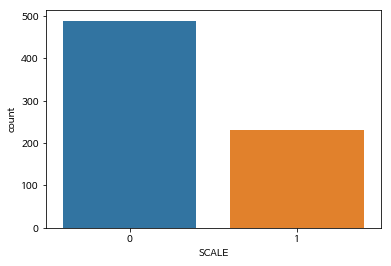

In [46]:
ax = sns.countplot(df_scale_y,label = "Count")
B,M= df_scale_y.value_counts()
print("number of 양품: ",B)
print("number of 불량: ",M)

<h3>char형 범주형 변수와 scale 빈도 수치적 확인 <h3>

In [47]:
def fun_print_crosstab(data,var):
    print(pd.crosstab(index = data["SCALE"],columns = data[var]))
    print()
    print(pd.crosstab(index = data["SCALE"],columns = data[var],normalize = "columns").round(3))
    

In [48]:
# 강종
fun_print_crosstab(df_scale,"STEEL_KIND")

STEEL_KIND   C0  C1  C3  T0  T1  T3  T5  T7  T8
SCALE                                          
0           291   0   6  14  16   2  41  29  90
1           212   1   1   2   2   0   2   6   5

STEEL_KIND     C0   C1     C3     T0     T1   T3     T5     T7     T8
SCALE                                                                
0           0.579  0.0  0.857  0.875  0.889  1.0  0.953  0.829  0.947
1           0.421  1.0  0.143  0.125  0.111  0.0  0.047  0.171  0.053


In [49]:
# 가열로 호기
fun_print_crosstab(df_scale,"FUR_NO")

FUR_NO  1호기  2호기  3호기
SCALE                
0       167  167  155
1        73   70   88

FUR_NO    1호기    2호기    3호기
SCALE                      
0       0.696  0.705  0.638
1       0.304  0.295  0.362


In [50]:
# WORK GR 작업조
fun_print_crosstab(df_scale,"WORK_GR")

WORK_GR   1조   2조   3조   4조
SCALE                      
0        122  120  118  129
1         67   45   54   65

WORK_GR     1조     2조     3조     4조
SCALE                              
0        0.646  0.727  0.686  0.665
1        0.354  0.273  0.314  0.335


In [51]:
fun_print_crosstab(df_scale,"HSB")

HSB    미적용   적용
SCALE          
0        0  489
1       33  198

HSB    미적용     적용
SCALE            
0      0.0  0.712
1      1.0  0.288


<h4> numeric 과 char를 분리해서, 상관관계 분석해보기 <h4>

<h4> 설명변수를 char & numeric 변수로 나누기 <h4>

In [77]:
# char & numeric 분리
df_scale_x_char = df_scale_x.select_dtypes(include = "object")
df_scale_x_num = df_scale_x.select_dtypes(exclude = "object")

In [78]:
df_scale_x_char.head()

,SPEC,STEEL_KIND,FUR_NO,WORK_GR
0,AB/EH32-TM,T1,1호기,2조
1,AB/EH32-TM,T1,1호기,2조
2,NV-E36-TM,T8,2호기,3조
3,NV-E36-TM,T8,2호기,3조
4,BV-EH36-TM,T8,3호기,1조


In [105]:
# char 변수 값 확인하기
for name in df_scale_x_char:
    print(df_scale_x_char[name].value_counts())
    

JS-SM490YB     84
LR-A           54
NV-A           48
PILAC-BT33     40
BV-EH36-TM     35
LR-AH32        33
NV-A32         33
JS-SM490A      31
BV-B           28
COMMON         28
KR-A           27
SA283-C        21
JS-SS400       19
AB/EH36-TM     17
GL-E36-TM      16
BV-AH32        14
LR-B           13
NK-KA32        12
GL-A36-TM      11
GL-D36-TM       8
GL-A32          8
KS-SM490B       7
AB/A            7
A283-C          6
AB/B            6
GL-E32-TM       6
JS-SM490YA      5
KS-SS400        5
NV-D36-TM       5
JS-SM400B       5
               ..
KS-SM400B       4
NV-D32-TM       4
GL-A32-TM       4
GL-A            3
BV-AH36-TL      3
NV-B            3
BV-AH32-TM      3
KR-AH32         3
NV-A32-TM       3
KS-HSB500       2
A516-60         2
JS-SM400A       2
AB/EH32-TM      2
NK-KD36-TM      2
LR-EH36-TM      2
API-2W-50T      2
NV-A36-TM       2
NV-E32-TM       2
KR-B            1
LR-EH32-TM      1
CCS-B           1
LR-AH36-TM      1
A709-36         1
KS-HSB600       1
BV-A      

<h3> bar_chart로 char 형 변수와 scale 관계 보기 <h3>

In [52]:
def bar_chart(feature):
    postive = df_scale[df_scale["SCALE"]==0][feature].value_counts()
    negative = df_scale[df_scale["SCALE"]==1][feature].value_counts()
    df = pd.DataFrame([postive,negative])
    df.index = ['양품','불량']
    df.plot(kind = 'bar', figsize= (10,5))
    

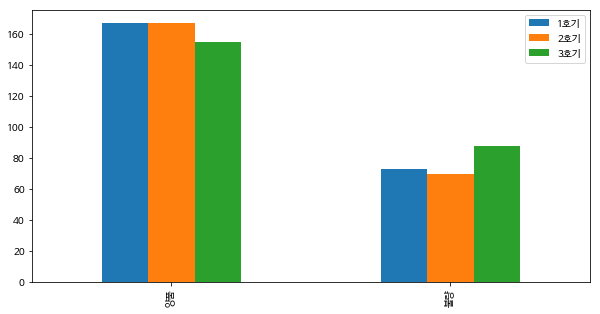

In [53]:
ㅇbar_chart("FUR_NO")
# 그래프를 보면 1호기와 2호기의 양품개수는 같고
# 불량의 경우 3호기가 가장 많다.
# 가열로 호기와 scale의 상관관계가 높을 듯하다.

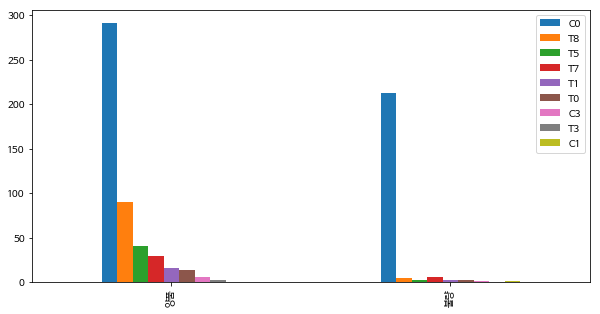

In [54]:
bar_chart("STEEL_KIND")
# 그래프를 보면 강종의 종류중 C0가 압도적으로 양품과 불량의 수가 많다
# C0의 강종으로 많이 생산되는것을 알 수 있다.
# 비율로 따지면, C0가 불량률이 제일 높다.

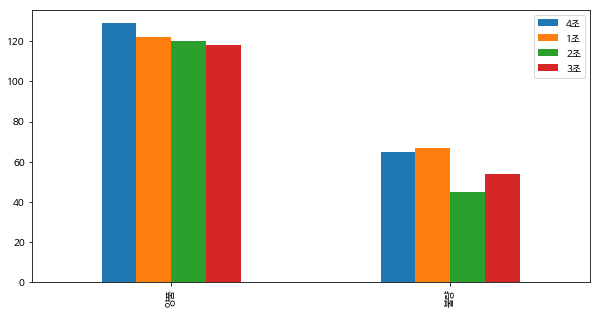

In [55]:
bar_chart("WORK_GR")
# 그램에서 보면, 불량의 경우 비율상 1조가 가장 많은 양이 나오고, 그다음으로 4조가 불량이 많이나온다.

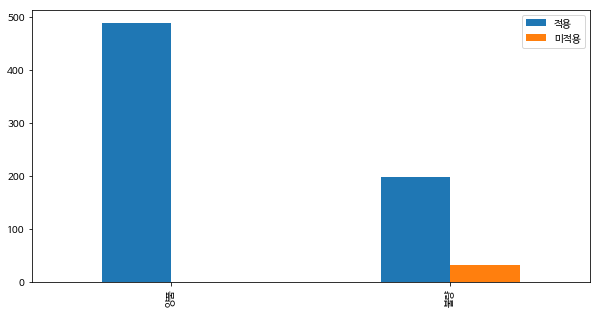

In [56]:
# HSB 적용한경우 양품밖에 없지만, 미적용시 불량이 조금생겼다.
bar_chart("HSB")

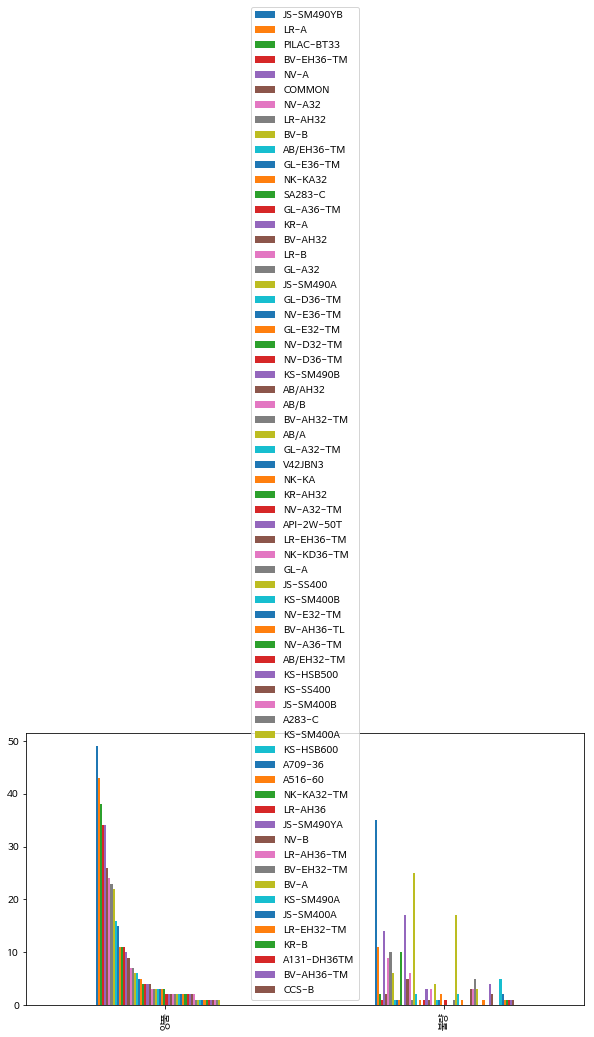

In [57]:
bar_chart("SPEC")

<h3> displot을 활용하여, 수치형 변수들의 분포살펴보기 <h3>

/home/pirl/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


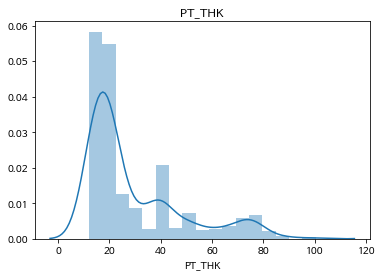

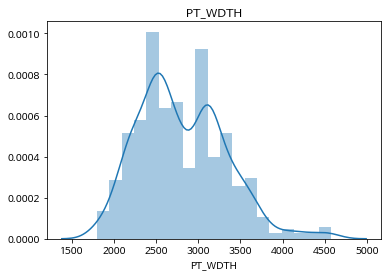

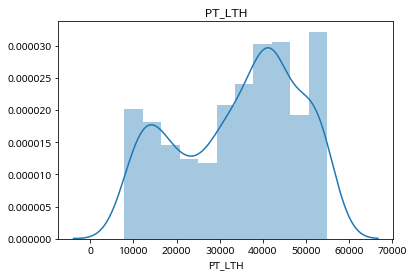

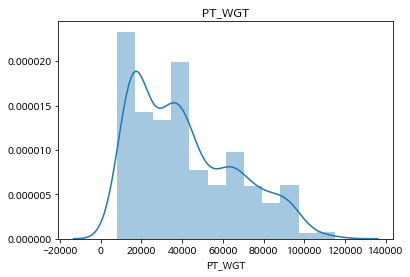

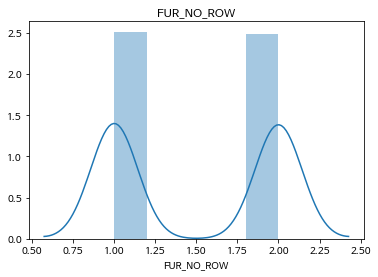

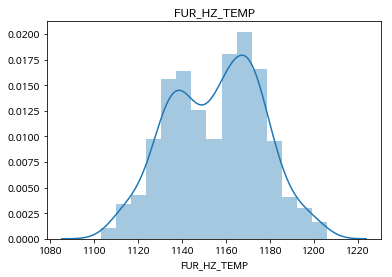

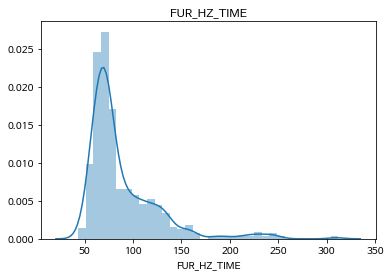

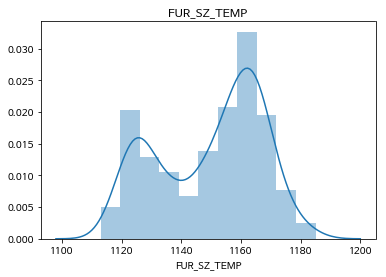

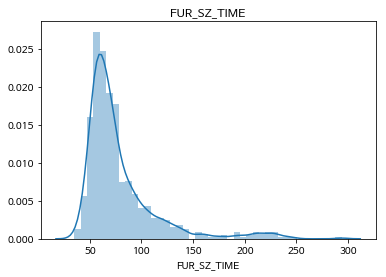

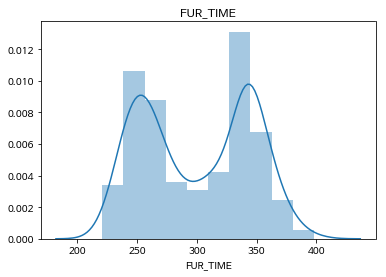

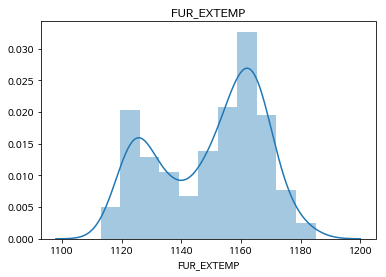

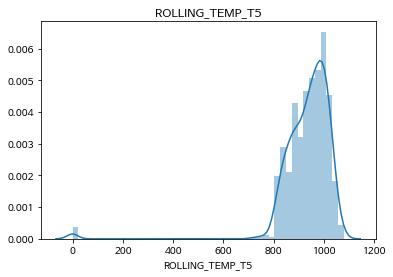

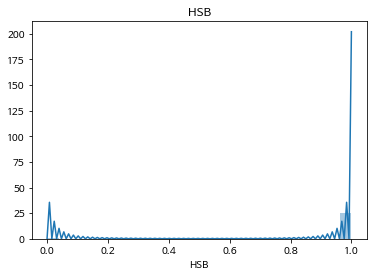

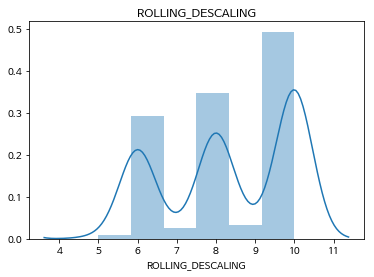

In [104]:
# distplot을 사용하여, 수치형 변수들의 분포살펴보기 
for col in df_scale_x_num:
    sns.distplot(df_scale_x.loc[df_scale_x[col].notnull(), col])
    plt.title(col)
    plt.show()



<h4> hist plot을 이용하여, 목표변수와의 관계 보기 <h4>

In [58]:
def hist_map(feature):
    grid = sns.FacetGrid(df_scale, col = "SCALE")
    grid.map(plt.hist,feature)

In [59]:
def hist_map2(feature):
    plt.hist(df_scale[df_scale["SCALE"]==1][feature],label = "불량",alpha = 0.5)
    plt.hist(df_scale[df_scale["SCALE"]==0][feature],label = "양품",alpha = 0.5)
    

<h3> plate 관련 변수별 scale(양품,불량) 밀도확인 <h3>

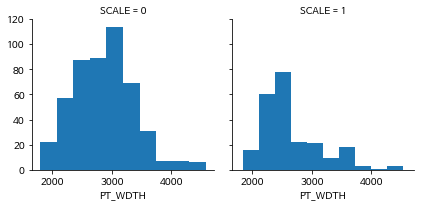

In [60]:
# PLATE 폭
hist_map("PT_WDTH")
# scale = 0 양품,  scale = 1 불량
# 폭이 2000~ 3000 사이에서 불량이 많이 발곗

           SCALE                 PT_WDTH               
            mean  sum count         mean      sum count
WDcat                                                  
폭<3000  0.398190  176   442  2468.124434  1090911   442
폭>3000  0.197842   55   278  3346.118705   930221   278


/home/pirl/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<BarContainer object of 2 artists>

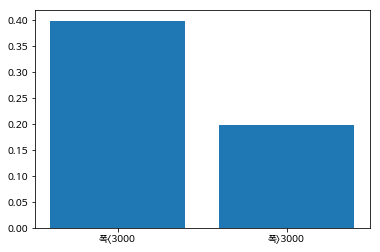

In [61]:
# plate폭을 3000 미만과 이상으로 나누워서 양품의 비율을 살펴보자
tmp_sc = df_scale[["SCALE","PT_WDTH"]]
tmp_sc.SCALE = df_scale_y
tmp_sc["WDcat"] = np.where(tmp_sc.PT_WDTH<3000,'폭<3000','폭>3000')
tmp_sc_agg = tmp_sc.groupby('WDcat',as_index = False).agg(['mean','sum','count'])
print(tmp_sc_agg)
# x축은 폭<3000,두께>3000 , y축은 scale양품의 비율
plt.bar(tmp_sc_agg.index,tmp_sc_agg["SCALE"]['mean'])
# 밑의 그래프를 해석해보면, 두께가 36미만인 plate들을 생산할때 , 상대적으로 양품이 나올 확률이 낮다.
# 밑의 표를 수치를 보면 불량률은 폭<3000(약40%) > 폭>3000(약20%) 2배정도 차이난다.

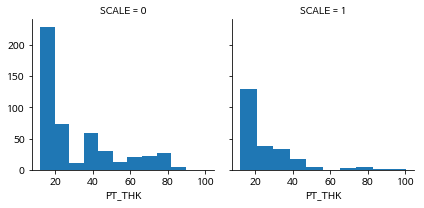

In [62]:
# PLATE 두께
hist_map("PT_THK")
# 두께가 20 미만인 plate를 만들때 가장 scaled이 많이 발생한다.

In [63]:
# df_scale_y.describe()다

          SCALE                PT_THK                 
           mean  sum count       mean        sum count
ptcat                                                 
두께<36  0.385519  197   511  18.676769   9543.829   511
두께>36  0.162679   34   209  55.162813  11529.028   209


/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<BarContainer object of 2 artists>

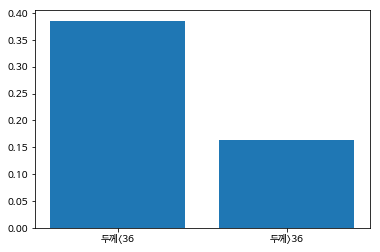

In [64]:
# 두께를 비율로 설명하면 두께와 불량율의 설명력이 높아진다.
tmp_sc = df_scale[["SCALE","PT_THK"]]
tmp_sc.SCALE = df_scale_y
tmp_sc["ptcat"] = np.where(tmp_sc.PT_THK<36,'두께<36','두께>36')
# 양품율 계산
tmp_sc_agg = tmp_sc.groupby('ptcat',as_index = False).agg(['mean','sum','count'])
print(tmp_sc_agg)
# x축은 두께<36,두께>36 , y축은 scale양품의 비율
plt.bar(tmp_sc_agg.index,tmp_sc_agg["SCALE"]['mean'])
# 밑의 그래프를 해석해보면, 두께가 36미만인 plate들을 생산할때 , 상대적으로 양품이 나올 확률이 낮다.
# 밑의 표를 수치를 보면 불량률은 두께<36(약38%) > 두께>36(약16%)2배이상정도 차이난다.

In [65]:
tmp_sc_agg

SCALE                PT_THK                 
           mean  sum count       mean        sum count
ptcat                                                 
두께<36  0.385519  197   511  18.676769   9543.829   511
두께>36  0.162679   34   209  55.162813  11529.028   209

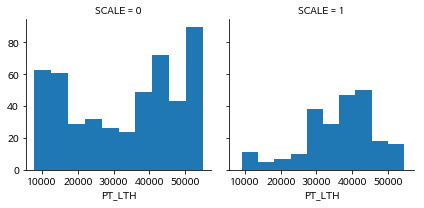

In [66]:
# PLATE 길이
hist_map("PT_LTH")
# 길이가 30m~ 50m로 plate를 만들 때 scale이 많이 발생한다.

           SCALE                   PT_LTH                
            mean  sum count          mean       sum count
LTcat                                                    
길이<30m  0.164609   40   243  17531.024691   4260039   243
길이>30m  0.400419  191   477  42877.809224  20452715   477


/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<BarContainer object of 2 artists>

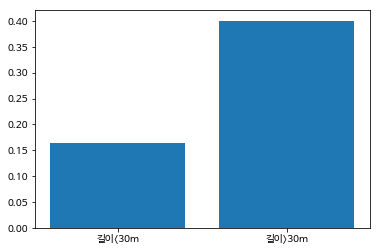

In [67]:
# 길이를 비율로 설명하면 길이와 불량율의 설명력이 높아진다.다
tmp_sc = df_scale[["SCALE","PT_LTH"]]
tmp_sc.SCALE = df_scale_y
tmp_sc["LTcat"] = np.where(tmp_sc.PT_LTH<30000,'길이<30m','길이>30m')
tmp_sc_agg = tmp_sc.groupby('LTcat',as_index = False).agg(['mean','sum','count'])
print(tmp_sc_agg)
# x축은 길이<30m, 길이>30m , y축은 scale양품의 비율
plt.bar(tmp_sc_agg.index,tmp_sc_agg["SCALE"]['mean'])
# 밑의 그래프를 해석해보면, 길이가 30m미만인 plate들을 생산할때 , 상대적으로 양품이 나올 확률이 높다.
# 밑의 표를 수치를 보면 불량률은 길이<30m(약16%) < 길이>30m(약40%)정도 차이난다.

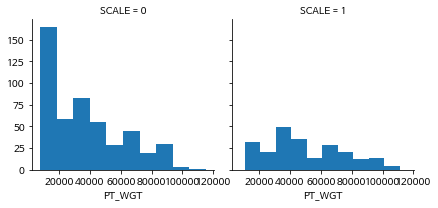

In [68]:
# PLATE 중량
hist_map("PT_WGT")

           SCALE                   PT_WGT                
            mean  sum count          mean       sum count
WTcat                                                    
중량<30톤  0.281426  150   533  29055.253283  15486450   533
중량>30톤  0.433155   81   187  76900.695187  14380430   187


/home/pirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<BarContainer object of 2 artists>

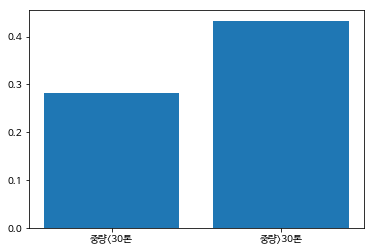

In [69]:
# 중량을 비율로 설명하면 중량와 불량율의 설명력이 높아진다.
tmp_sc = df_scale[["SCALE","PT_WGT"]]
tmp_sc.SCALE = df_scale_y
tmp_sc["WTcat"] = np.where(tmp_sc.PT_WGT<60000,'중량<30톤','중량>30톤')
tmp_sc_agg = tmp_sc.groupby('WTcat',as_index = False).agg(['mean','sum','count'])
print(tmp_sc_agg)
# x축은 중량<30톤, 중량>30톤 , y축은 scale양품의 비율
plt.bar(tmp_sc_agg.index,tmp_sc_agg["SCALE"]['mean'])
# 30톤 미만에서 양품률이 더 높다.
# 밑의 그래프를 해석해보면, 중량이 30톤 미만인 plate들을 생산할때 , 상대적으로 양품이 나올 확률이 높다.
# 밑의 표를 수치를 보면 불량률은 중량<30톤(약28%) < 중량>30톤(약44%)정도 차이난다.

<h3> 가열로 변수별 scale(양품,불량) 밀도보기 <h3>

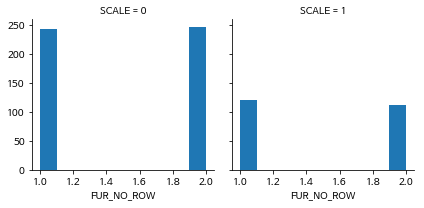

In [70]:
# 가열로 작업순번
hist_map("FUR_NO_ROW")

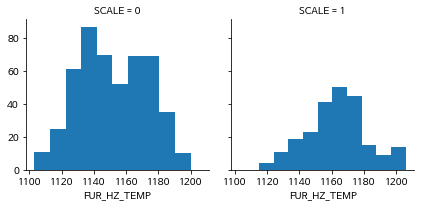

In [71]:
# 가열로 가열대 온도
hist_map("FUR_HZ_TEMP")

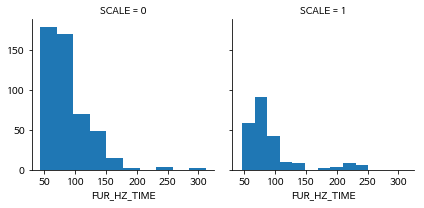

In [72]:
# 가열로 가열대 시간
hist_map("FUR_HZ_TIME")

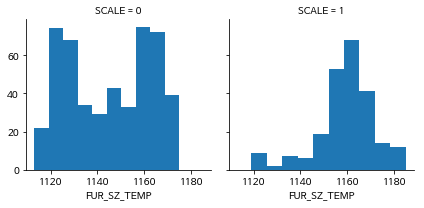

In [73]:
# 가열로 균열대 온도
hist_map("FUR_SZ_TEMP")

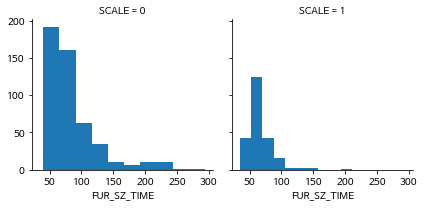

In [74]:
# 가열로 균열대 시간
hist_map("FUR_SZ_TIME")

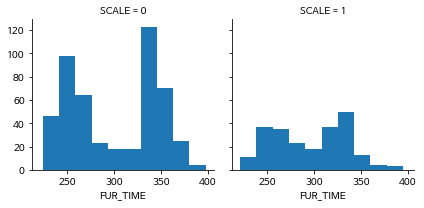

In [75]:
# 가열로 시간
hist_map("FUR_TIME")

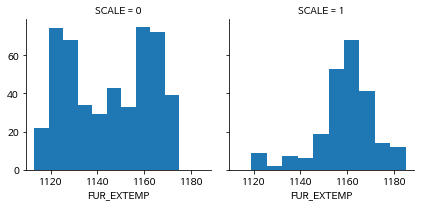

In [76]:
# 가열로 탈출 온도
hist_map("FUR_EXTEMP")

In [81]:
df_scale_x_num.head()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING
0,32.25,3707,15109,14180,1,1144,116,1133,59,282,1133,934,1,8
1,32.25,3707,15109,14180,2,1144,122,1135,53,283,1135,937,1,8
2,33.27,3619,19181,18130,1,1129,116,1121,55,282,1121,889,1,8
3,33.27,3619,19181,18130,2,1152,125,1127,68,316,1127,885,1,8
4,38.33,3098,13334,12430,1,1140,134,1128,48,314,1128,873,1,8


<h4> char형 데이터와 scale간의 상관관계를 보기 <h4>

In [95]:
df_scale.describe()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,ROLLING_DESCALING
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.679167,29.267857,2807.127778,34323.269444,41481.777778,1.497222,1155.338889,88.527778,1149.666667,78.802778,300.563889,1149.666667,933.920833,8.319444
std,0.467121,19.152651,517.839690,13828.434837,24751.322015,0.500340,20.866398,37.660799,17.571788,36.421004,45.390303,17.571788,107.863887,1.623252
min,0.000000,12.030000,1800.000000,7893.000000,7820.000000,1.000000,1103.000000,43.000000,1113.000000,35.000000,221.000000,1113.000000,0.000000,5.000000
25%,0.000000,16.090000,2466.000000,22663.000000,17757.500000,1.000000,1139.000000,65.000000,1132.000000,57.750000,257.000000,1132.000000,889.750000,6.000000
50%,1.000000,20.130000,2725.000000,37380.000000,36120.000000,1.000000,1158.000000,75.000000,1155.000000,67.500000,304.000000,1155.000000,951.000000,8.000000
75%,1.000000,40.000000,3125.000000,43735.000000,61120.000000,2.000000,1171.000000,101.000000,1164.000000,86.000000,342.000000,1164.000000,994.250000,10.000000
max,1.000000,100.340000,4575.000000,54917.000000,115080.000000,2.000000,1206.000000,312.000000,1185.000000,294.000000,398.000000,1185.000000,1078.000000,10.000000
